In [5]:
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn import metrics
import unidecode
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime
import re
import random

In [6]:
df = pd.read_csv('tweets_public.csv', encoding='utf-16', index_col='tweet_id', sep=',')
df.columns.tolist()

['airline_sentiment',
 'is_reply',
 'reply_count',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [7]:
def delete_urlvideo(tweet):
    #Delete URLs www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    #Delete VIDEO
    tweet = re.sub('((\[VIDEO\])|(#VIDEO)|#vIDEO)','',tweet)
    return tweet

In [8]:
def remove_duplicated_tweets(df):
    # Delete duplicated tweets
    df['text'] = df['text'].apply(delete_urlvideo)
    df2 = df.drop_duplicates(subset='text',keep=False) 
    return df2

# First steps:
We create here a column named "weekday_names" in which we write the dat that the tweet was written
We also create a column names "hoursday" in which we write the hour of the day in which the tweet was written

In [9]:
df1 = remove_duplicated_tweets(df)
weekdays = pd.to_datetime(df1.tweet_created).dt.dayofweek
hoursday = pd.to_datetime(df1.tweet_created).dt.hour
df1['weekday'] = pd.Series(weekdays, index=df1.index)
df1['hoursday'] = pd.Series(hoursday, index=df1.index)
weekday_names = []
wn = ['lunes', 'martes', 'miercoles', 'jueves', 'viernes', 'sabado', 'domingo']
for d in df1.weekday:
    weekday_names.append(wn[d])
df1['weekday_names'] = pd.Series(weekday_names, index=df1.index)
df1.tweet_created = pd.to_datetime(df1.tweet_created)

/Users/pere/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/pere/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/pere/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

# Function to create the submit file

In [10]:
def create_submit_file(df_submission, ypred):
    date = datetime.datetime.now().strftime("%m_%d_%Y-%H_%M_%S")
    filename = 'submission_' + date + '.csv'

    df_submission['airline_sentiment'] = ypred
    df_submission[['airline_sentiment']].to_csv(filename)

    print('Submission file created: {}'.format(filename))
    print('Upload it to Kaggle InClass')


# Stemlematizer
This function takes the text in a tweet and reduces each word to its stem first, and then applies a lemmatization. As a result, a new dataframe is created, substituting the "text" column in the old one by the stemed-lematized text

In [11]:
def stemlematizer(df):
    """ Function to reduce the words to their root
    """
    lemmer=WordNetLemmatizer()
    stemmer = SnowballStemmer('spanish')

    new_corpus1 = [' '.join([stemmer.stem(word) for word in tweet.split(' ')]) for tweet in df.text.values]
    new_corpus = [' '.join([lemmer.lemmatize(word) for word in tweet.split(' ')]) for tweet in new_corpus1] 
    
    df.text = new_corpus
    return df

# This function is not used anymore in this notebook...

In [12]:
def load_and_train(dataframe, trainmodelclassifier, test=None, *model_args, **model_kwargs ):

# If there is no test data, split the input
    if test is None:
        train, test = train_test_split(dataframe, test_size=0.25)
    else:
        train = dataframe

    dataframe.airline_sentiment = pd.Categorical(dataframe.airline_sentiment)
    
    x_train = train['text']
    y_train = train['airline_sentiment']
    
    x_test = test['text']
    #we create the list of stop words specific for spanish:
    spanish_stop_words = stopwords.words('spanish')
    #we build the classifier, that has everything inside:
    text_clf = Pipeline([('vect', CountVectorizer(min_df=1,
                                              stop_words=spanish_stop_words, ngram_range=(1,2), 
                                              analyzer='word', token_pattern=r'[^@]\b\w+\b')),
                     ('tfidf', TfidfTransformer(norm='l2')),
                     ('clf', trainmodelclassifier(*model_args, **model_kwargs))])

    

# SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None))])

    text_clf.fit(x_train, y_train)
    predicted = text_clf.predict(x_test)

    try:
        y_test = test['airline_sentiment'].values
    except:
        # It might be the submision file, where we don't have target values
        y_test = None
   
    try:
        acc = accuracy_score(test.airline_sentiment, predicted)
        print('accuracy_score = ', acc)
    except:
        print('No accuracy computed beacuse there is NO test target')
        acc = None
    return predicted, x_train, y_train, x_test, y_test, acc


# Cleaning functions:

Those are a set of functions that clean a bit more the text: convert all into lower case, take the @ from usernames, take the # from hashtags, etc.

In [13]:
def processTweet2(tweet):
    # process the tweets
    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Remove usernames
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Remove #word with word
    tweet = re.sub(r'#([^\s]+)', '', tweet)
    #tweet = re.sub(r'\#\w+','',tweet)
    return tweet  

def handle_emojis(tweet):
    tweet = re.sub(r'CC:', ' EMOPOS ', tweet)
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMOPOS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMOPOS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMOPOS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMOPOS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMONEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMONEG ', tweet)
    return tweet

def preprocess_word(word):
    # Remove punctuation
    #word = word.strip('\'"?!,.():;')
    word = word.strip('\'"?!,.')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    # remove numbers
    word = re.sub(r'\d+','',word)
    #remove users 
    word = re.sub(r'AT_USER','',word)
    word = re.sub(r'URL','',word)
    word = re.sub(r'rt','',word)
    word = re.sub(r'via','',word)
    word = re.sub('\s+', ' ', word)
    #Delete via, rt and by
    word = re.sub(r'\brt\b','',word)
    word = re.sub(r'\bvia\b','',word)
    word = re.sub(r'\bby\b','',word)
    # Remove numbers
    word = re.sub(r'\d+','',word)
    # Remove single characters
    word = re.sub(r'\b\w\b','',word)
    # Remove accents
    word = unidecode.unidecode(word)

    return word

def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)

In [14]:
tweets = [handle_emojis(tweet) for tweet in df1.text.values]
tweets2 = [processTweet2(tweet) for tweet in tweets]
tweets3 = [' '.join(preprocess_word(word) for word in tweet.split(' ')) for tweet in tweets2]
df1.text = tweets3
df1.text.values
df1 = stemlematizer(df1)

/Users/pere/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Here we create the list of hour names, as strings, in order to fill it with the value of the hour at which the tweet was written

In [15]:
hh = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
hh_names = ['zero', 'una', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'once', 'doce', 'trece', 'catorce', 'quince', 'dieciseis', 'diecisiete', 'dieciocho', 'diecinueve', 'veinte', 'veintiuno', 'veintios', 'veintitres']

In [16]:
#we create the list of stop words specific for spanish:
spanish_stop_words = stopwords.words('spanish')
count_vect = CountVectorizer(min_df=1, stop_words=spanish_stop_words, ngram_range=(1,2), analyzer='word', token_pattern=r'[^@]\b\w+\b')
X_train_counts = count_vect.fit_transform(df1.text.values)
voc = count_vect.vocabulary_
X_train_counts = X_train_counts.toarray()

We fill the columns named as the hours with a 1 at the hour at which the tweet was written, and a 0 in all the other columns

In [17]:
for i in hh_names:
    ind = df1.query('hoursday == @i').index
    df1.loc[ind,i] = 1

/Users/pere/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/pere/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Then we copy these columns into the bag of words matrix

In [18]:
for h in hh_names:
    col = np.array(df1[h].fillna(value = 0))
    np.column_stack((X_train_counts,col))   

We do the same for the week days: first we create the columns with the names, and we fill them: we put 1 in the day at which the tweet was written, and 0 in all the other days. Then we copy these columns into the bag-of-words matrix. We do not use this feature anymore, since it was not adding any information to the model

In [15]:
#for i in np.unique(np.array(df1['weekday_names'])):
#    ind = df1.query('weekday_names == @i').index
#    df1.loc[ind,i] = 1
#for d in wn:
#    col = np.array(df1[d].fillna(value = 0))
#    np.column_stack((X_train_counts,col))


We apply a Tfidf transformation in order to pass from absolute values to frequencies in the bag.of.words matrix. We then split the matrix into test and train and apply a classifier model, and test our training with the test sub-matrix

In [19]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
features_train,features_test,label_train,label_test = \
train_test_split(X_train_tfidf, df1.airline_sentiment.values,test_size=0.0001,random_state = 123)
sgc = SGDClassifier(penalty = 'elasticnet',max_iter = 10)
svm = LinearSVC()
sgc.fit(features_train,label_train)
svm.fit(features_train,label_train)
score = sgc.score(features_test,label_test)
scoresvm = svm.score(features_test, label_test)
print(score)
print(scoresvm)

1.0
1.0


In the next cell I try to compute the accuracy with another function (predict first, and then accuracy_score). The results are the same as before

In [20]:
y_test_prediction = sgc.predict(features_test)
acc = accuracy_score(label_test, y_test_prediction)
print(acc)

1.0


In the next cell I use the pipeline function load_and_train in order to compare it with the above result:

In the above process, we add to the bag-of-words matrix some extra columns, as the day of the week or the hour of the day.
In the next cell, these informations are not taken into account

In [18]:
predicted, x_train, y_train, x_test, y_test, acc = load_and_train(df1, SGDClassifier, test=None, penalty='elasticnet', max_iter=10)

/Users/pere/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


accuracy_score =  0.607819905213


As can be seen, the results are pretty much the same...

Here I do the processing of the tweets_submission.csv file, with the created model above. The procedure is exactly the same as before, except that here we use the bag-of-words created before

In [19]:
df0_s = pd.read_csv('tweets_submission.csv', index_col='tweet_id', sep=',')
# Keep relevant columns only
df1_s = df0_s.drop(['retweet_count','is_reply','reply_count','tweet_coord','tweet_location','user_timezone'], axis=1)
df1_s['text'] = df1_s['text'].apply(delete_urlvideo)#df.head()
#df_s['text'] = df_s['text'].apply(basicCleaning)
#df_s['airline'] = df_s['text'].apply(extract_airline)
# From 'airline' column create a one-hot encoding matrix for airline name
#tweet_airline = df_s['airline'].str.split(r'|', expand=True).stack().reset_index(level='tweet_id')
#tweet_airline.columns = ['tweet_id','airline']
#tweet_airline = tweet_airline.set_index('tweet_id')
# One-hot encoding for airline name
#onehot = pd.get_dummies(tweet_airline['airline'])
#df_airlines = onehot.groupby('tweet_id').sum()

# Concatenate the two dataframes (original+one-hot airlines) and delete the airline column
#merged = pd.concat([df_s, df_airlines], axis=1, join_axes=[df_s.index])
#df1_s = merged.drop('airline', axis=1)
#df1_s['text'] = df1_s['text'].apply(moreCleaning)

weekdays = pd.to_datetime(df1_s.tweet_created).dt.dayofweek
hoursday = pd.to_datetime(df1_s.tweet_created).dt.hour
df1_s['weekday'] = pd.Series(weekdays, index=df1_s.index)
df1_s['hoursday'] = pd.Series(hoursday, index=df1_s.index)
weekday_names = []
wn = ['lunes', 'martes', 'miercoles', 'jueves', 'viernes', 'sabado', 'domingo']
for d in df1_s.weekday:
    weekday_names.append(wn[d])
df1_s['weekday_names'] = pd.Series(weekday_names, index=df1_s.index)
df1_s.tweet_created = pd.to_datetime(df1_s.tweet_created)



tweets = [handle_emojis(tweet) for tweet in df1_s.text.values]
tweets2 = [processTweet2(tweet) for tweet in tweets]
tweets3 = [' '.join(preprocess_word(word) for word in tweet.split(' ')) for tweet in tweets2]
df1_s.text = tweets3
df1_s.text.values
df1_s = stemlematizer(df1_s)

count_vect = CountVectorizer(vocabulary=voc, min_df=1, stop_words=spanish_stop_words, ngram_range=(1,2), analyzer='word', token_pattern=r'[^@]\b\w+\b')
X_submission_counts = count_vect.fit_transform(df1_s.text.values)
X_submission_counts = X_submission_counts.toarray()

for i in hh_names:
    ind = df1_s.query('hoursday == @i').index
    df1_s.loc[ind,i] = 1

for h in hh_names:
    col = np.array(df1_s[h].fillna(value = 0))
    np.column_stack((X_submission_counts,col))    
    
#for i in np.unique(np.array(df1_s['weekday_names'])):
#    ind = df1_s.query('weekday_names == @i').index
#    df1_s.loc[ind,i] = 1
#for d in wn:
#    col = np.array(df1_s[d].fillna(value = 0))
#    np.column_stack((X_submission_counts,col))

X_submission_tfidf = tfidf_transformer.transform(X_submission_counts)
#features_train,features_test,label_train,label_test = \
#train_test_split(X_submission_tfidf, df1_s.airline_sentiment.values,test_size=1.00,random_state = 123)
#sgc = SGDClassifier(penalty = 'elasticnet',max_iter = 10)
#svm = LinearSVC()
#sgc.fit(features_train,label_train)
#svm.fit(features_train,label_train)
prediction_sgc = sgc.predict(X_submission_tfidf)


In [20]:
create_submit_file(df0_s, prediction_sgc)

Submission file created: submission_06_13_2018-16_42_06.csv
Upload it to Kaggle InClass


In [21]:
predicted, x_train, y_train, x_test, y_test, acc = load_and_train(df1, SGDClassifier, test=df1_s, penalty='elasticnet', max_iter=10)

/Users/pere/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


No accuracy computed beacuse there is NO test target


In [22]:
create_submit_file(df0_s, predicted)

Submission file created: submission_06_13_2018-16_42_07.csv
Upload it to Kaggle InClass


# Confusion matrix

classification accuracy: 1.0


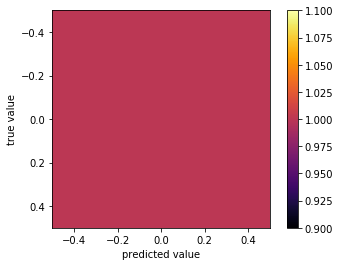

             precision    recall  f1-score   support

   negative       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         1



In [21]:
def plot_confusion_matrix(y, y_pred):
    plt.imshow(metrics.confusion_matrix(y, y_pred),
               cmap='inferno', interpolation='nearest')
    plt.colorbar()
    plt.ylabel('true value')
    plt.xlabel('predicted value')
    plt.show()
    
print ("classification accuracy:", metrics.accuracy_score(label_test, y_test_prediction))
plot_confusion_matrix(label_test, y_test_prediction)
print(metrics.classification_report(label_test,y_test_prediction))

We label well the negatives, but still label many neutral as negatives.

In [24]:
len(df1_s)

1967

In [37]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vect, sgc, 10)

3

In [38]:
importance

{0: {'tops': [(2.868892514668823, ' put'),
   (2.8796479073861017, ' cancel'),
   (2.8947089634946828, ' impos'),
   (2.993346288531777, ' mal'),
   (3.0547467261192365, ' no  pued'),
   (3.055229989582493, ' peor'),
   (3.0828878684014343, ' car'),
   (3.1645995715564683, ' cobr'),
   (3.516236370655021, ' malet'),
   (5.065930498516597, ' no')],
  'bottom': [(-1.829780079735571, ' sol  con'),
   (-1.8360494585715617, ' visit'),
   (-1.870326634138306, ' no  vam'),
   (-1.9012630084308575, ' hol'),
   (-1.9673805449257415, ' mejor'),
   (-1.9855164574878368, ' nuev'),
   (-2.130141563406409, ' de  un'),
   (-2.3640405694802955, ' felic'),
   (-2.4349837934667713, ' fot'),
   (-4.723020765144235, ' graci')]},
 1: {'tops': [(1.792276617288971, ' niki'),
   (1.8040314219136369, ' iberi  la'),
   (1.811622817755442, ' un  vuel'),
   (1.8797865985560163, ' vuel  e'),
   (1.9209054411047148, ' europe'),
   (1.9330068456146385, ' gan'),
   (2.1279915374413516, ' par  trabaj'),
   (2.51027904

In [54]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('More relevant', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    fig.savefig('relevant_words_for_negative.png', bbox_inches='tight')


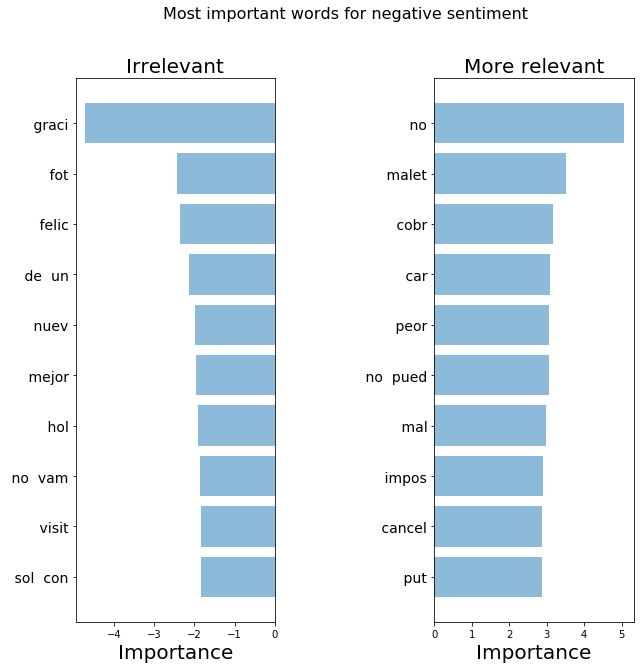

In [55]:
index_sentiment = 0

top_scores = [a[0] for a in importance[index_sentiment]['tops']]
top_words = [a[1] for a in importance[index_sentiment]['tops']]

medium_scores = [a[0] for a in importance[index_sentiment]['tops']]
medium_words = [a[1] for a in importance[index_sentiment]['tops']]

bottom_scores = [a[0] for a in importance[index_sentiment]['bottom']]
bottom_words = [a[1] for a in importance[index_sentiment]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for negative sentiment")

In [53]:
len(df)

7867